In [1]:
import pandas as pd
import librosa
import librosa.display
import csv
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import seaborn as sns
%matplotlib inline
import os
from PIL import Image

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import LabelBinarizer
from keras import models
from keras import layers
from keras.utils import np_utils
import tensorflow as tf
import keras


import warnings
warnings.filterwarnings('ignore')
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense , Activation , Dropout,BatchNormalization
plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

# Modeling

In [2]:
song_data=pd.read_csv('song_data.csv',index_col=0)

In [4]:
song_data

,gnr_code,mel_mean1,mel_var1,mel_mean2,mel_var2,mel_mean3,mel_var3,mel_mean4,mel_var4,mel_mean5,...,mel_mean44,mel_var44,mel_mean45,mel_var45,mel_mean46,mel_var46,mel_mean47,mel_var47,mel_mean48,mel_var48
0,클래식,-22.287693,29.279341,-21.811888,32.238495,-18.731527,33.485657,-18.496843,73.681168,-15.751297,...,-76.075195,30.897482,-77.288597,27.107990,-78.270287,26.208948,-80.143806,23.749142,-87.623306,24.902794
1,록/메탈,-5.962391,164.708191,-5.269400,156.650024,-7.788965,172.436356,-12.323392,190.411636,-13.889373,...,-26.620602,55.141689,-25.791874,53.102703,-26.686378,62.576958,-28.202204,63.855526,-35.782257,62.882446
2,록/메탈,-15.672803,61.052334,-8.396144,44.536697,-10.794440,26.851456,-15.538502,33.989197,-16.615633,...,-61.476547,33.054832,-65.479027,53.141960,-68.703278,73.615791,-70.250175,73.298058,-78.002029,80.663559
3,록/메탈,-0.651627,59.577152,0.886999,46.364414,-2.050753,32.145187,-5.367093,27.931442,-8.142079,...,-26.981031,42.079399,-26.912186,34.388931,-27.960892,34.131721,-30.832115,43.725037,-39.697147,51.316116
4,록/메탈,6.895680,27.149529,5.090122,21.877079,2.955578,23.950787,0.589654,30.271410,-2.522650,...,-15.631028,13.141516,-18.265188,21.818455,-18.699680,24.931423,-20.146847,22.954941,-28.947878,25.681965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26372,발라드,-16.126869,35.199886,-10.342628,41.845375,-9.456706,90.855873,-10.068257,149.038330,-10.202171,...,-60.052151,190.009476,-61.873226,176.886963,-61.286446,211.014526,-60.880230,246.487534,-68.433525,264.282776
26373,록/메탈,-5.258698,183.995148,-2.156284,67.000534,-1.081643,54.025219,-0.075378,39.829166,-3.422323,...,-35.441559,118.709404,-33.121429,139.402893,-32.091743,156.059540,-33.071774,167.853317,-41.317440,179.756516
26374,록/메탈,10.265122,33.506046,8.323609,18.134287,3.737123,24.675570,-0.550394,31.456841,-0.736396,...,-14.546819,11.224085,-17.007765,8.702065,-17.847815,8.759120,-19.820023,10.701080,-29.453915,13.130124
26375,록/메탈,-4.552465,73.600410,2.505409,41.080330,-1.913496,33.796131,-5.874303,51.560619,-8.274634,...,-36.885544,79.399734,-37.999718,77.766556,-38.455574,81.719467,-39.259228,80.511101,-47.174149,80.680489


In [1204]:
# 클래식, 랩/힙합과 같이 장르의 특징이 뚜렷한 장르의 데이터 수를 감소시켜 장르별 정확도의 밸런스 조절
song_classic=song_data[song_data['gnr_code']=='클래식'].sample(3000)
song_rap=song_data[song_data['gnr_code']=='랩/힙합'].sample(4000)
song_ballade=song_data[song_data['gnr_code']=='발라드']
song_rock=song_data[song_data['gnr_code']=='록/메탈']

In [1205]:
song_data=pd.concat([song_classic,song_rap,song_ballade,song_rock])

In [1206]:
song_data.shape

(19974, 97)

In [1207]:
num_classes = 4

# One-Hot Encoding

In [1208]:
genre_list = song_data['gnr_code']
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
Y=np_utils.to_categorical(y)

In [1209]:
genre_list

20361     클래식
5896      클래식
16144     클래식
19302     클래식
6297      클래식
         ... 
26368    록/메탈
26370    록/메탈
26373    록/메탈
26374    록/메탈
26375    록/메탈
Name: gnr_code, Length: 19974, dtype: object

In [1210]:
Y

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [1211]:
encoder.classes_

array(['랩/힙합', '록/메탈', '발라드', '클래식'], dtype=object)

# Standardization

In [1212]:
scaler = StandardScaler() # 표준화
X = scaler.fit_transform(np.array(song_data.iloc[:, 1:], dtype = float))

In [1213]:
X,y = shuffle(X,Y, random_state=2)

# Train, Test set Split

In [1214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2)

In [1215]:
len(y_train)

15979

In [1216]:
len(y_test)

3995

# K-fold Cross Validation

In [1220]:
from sklearn.model_selection import KFold

In [1221]:
kf = KFold(n_splits=5, shuffle=False)

In [1222]:
BS = 512
EPOCHS =130 # 100 -> 130 변경

In [1223]:
result = []
scores_loss = []
scores_acc = []
k_no = 0
for train_index, test_index in kf.split(X):
    X_Train_ = X[train_index]
    Y_Train = y[train_index]
    X_Test_ = X[test_index]
    Y_Test = y[test_index]

    file_path = "weights_best_"+str(k_no)+".hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=0, save_best_only=True, mode='min')
    early = EarlyStopping(monitor="loss", mode="min", patience=8)

    callbacks_list = [checkpoint, early]


    model = models.Sequential()
    model.add(layers.Dense(120, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3)) 
    model.add(layers.Dense(45, activation='relu'))
    model.add(Dropout(0.3)) 
    model.add(layers.Dense(30, activation='relu'))
    model.add(Dropout(0.3)) 
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    with tf.device("/device:GPU:0"):
        hist=model.fit(X_Train_, Y_Train, batch_size=BS, epochs=EPOCHS, validation_data=(X_Test_, Y_Test), verbose=1)
    model.save_weights(file_path)
    result.append(model.predict(X_Test_))
    score = model.evaluate(X_Test_,Y_Test, verbose=0)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    k_no+=1

Epoch 1/130
32/32 [==============================] - 1s 10ms/step - loss: 1.1880 - accuracy: 0.4689 - val_loss: 0.8979 - val_accuracy: 0.6543
Epoch 2/130
32/32 [==============================] - 0s 5ms/step - loss: 0.9642 - accuracy: 0.5967 - val_loss: 0.7760 - val_accuracy: 0.6934
Epoch 3/130
32/32 [==============================] - 0s 5ms/step - loss: 0.8700 - accuracy: 0.6512 - val_loss: 0.7225 - val_accuracy: 0.7139
Epoch 4/130
32/32 [==============================] - 0s 5ms/step - loss: 0.8133 - accuracy: 0.6814 - val_loss: 0.6828 - val_accuracy: 0.7322
Epoch 5/130
32/32 [==============================] - 0s 5ms/step - loss: 0.7727 - accuracy: 0.7006 - val_loss: 0.6541 - val_accuracy: 0.7434
Epoch 6/130
32/32 [==============================] - 0s 4ms/step - loss: 0.7407 - accuracy: 0.7141 - val_loss: 0.6299 - val_accuracy: 0.7517
Epoch 7/130
32/32 [==============================] - 0s 5ms/step - loss: 0.7194 - accuracy: 0.7236 - val_loss: 0.6112 - val_accuracy: 0.7592
Epoch 8/130


Epoch 59/130
32/32 [==============================] - 0s 6ms/step - loss: 0.5368 - accuracy: 0.7999 - val_loss: 0.5149 - val_accuracy: 0.8018
Epoch 60/130
32/32 [==============================] - 0s 6ms/step - loss: 0.5276 - accuracy: 0.8009 - val_loss: 0.5187 - val_accuracy: 0.7995
Epoch 61/130
32/32 [==============================] - 0s 6ms/step - loss: 0.5256 - accuracy: 0.8027 - val_loss: 0.5157 - val_accuracy: 0.7975
Epoch 62/130
32/32 [==============================] - 0s 6ms/step - loss: 0.5248 - accuracy: 0.8021 - val_loss: 0.5191 - val_accuracy: 0.8015
Epoch 63/130
32/32 [==============================] - 0s 6ms/step - loss: 0.5278 - accuracy: 0.8017 - val_loss: 0.5117 - val_accuracy: 0.8053
Epoch 64/130
32/32 [==============================] - 0s 6ms/step - loss: 0.5214 - accuracy: 0.8029 - val_loss: 0.5218 - val_accuracy: 0.8003
Epoch 65/130
32/32 [==============================] - 0s 7ms/step - loss: 0.5258 - accuracy: 0.8016 - val_loss: 0.5114 - val_accuracy: 0.8025
Epoch 

32/32 [==============================] - 0s 4ms/step - loss: 0.5527 - accuracy: 0.7938 - val_loss: 0.5512 - val_accuracy: 0.7845
Epoch 44/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5498 - accuracy: 0.7949 - val_loss: 0.5503 - val_accuracy: 0.7847
Epoch 45/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5418 - accuracy: 0.7959 - val_loss: 0.5489 - val_accuracy: 0.7865
Epoch 46/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5409 - accuracy: 0.7970 - val_loss: 0.5511 - val_accuracy: 0.7845
Epoch 47/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5473 - accuracy: 0.7968 - val_loss: 0.5489 - val_accuracy: 0.7870
Epoch 48/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5390 - accuracy: 0.7970 - val_loss: 0.5446 - val_accuracy: 0.7860
Epoch 49/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5482 - accuracy: 0.7962 - val_loss: 0.5524 - val_accuracy: 0.7872
Epoch 50/130
32/32 

Epoch 101/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4774 - accuracy: 0.8215 - val_loss: 0.5371 - val_accuracy: 0.7905
Epoch 102/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4776 - accuracy: 0.8198 - val_loss: 0.5413 - val_accuracy: 0.7852
Epoch 103/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4741 - accuracy: 0.8233 - val_loss: 0.5414 - val_accuracy: 0.7907
Epoch 104/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4681 - accuracy: 0.8255 - val_loss: 0.5402 - val_accuracy: 0.7902
Epoch 105/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4684 - accuracy: 0.8236 - val_loss: 0.5419 - val_accuracy: 0.7912
Epoch 106/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4660 - accuracy: 0.8239 - val_loss: 0.5477 - val_accuracy: 0.7882
Epoch 107/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4756 - accuracy: 0.8233 - val_loss: 0.5369 - val_accuracy: 0.7905

Epoch 86/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4996 - accuracy: 0.8106 - val_loss: 0.5246 - val_accuracy: 0.7985
Epoch 87/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5006 - accuracy: 0.8129 - val_loss: 0.5242 - val_accuracy: 0.7940
Epoch 88/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4983 - accuracy: 0.8147 - val_loss: 0.5214 - val_accuracy: 0.7952
Epoch 89/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5003 - accuracy: 0.8129 - val_loss: 0.5265 - val_accuracy: 0.7970
Epoch 90/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4982 - accuracy: 0.8138 - val_loss: 0.5180 - val_accuracy: 0.8013
Epoch 91/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4970 - accuracy: 0.8134 - val_loss: 0.5262 - val_accuracy: 0.7955
Epoch 92/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4877 - accuracy: 0.8171 - val_loss: 0.5225 - val_accuracy: 0.7977
Epoch 

Epoch 71/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5188 - accuracy: 0.8067 - val_loss: 0.5261 - val_accuracy: 0.7995
Epoch 72/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5093 - accuracy: 0.8077 - val_loss: 0.5209 - val_accuracy: 0.7990
Epoch 73/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5028 - accuracy: 0.8106 - val_loss: 0.5215 - val_accuracy: 0.7967
Epoch 74/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5029 - accuracy: 0.8126 - val_loss: 0.5244 - val_accuracy: 0.7970
Epoch 75/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5016 - accuracy: 0.8126 - val_loss: 0.5212 - val_accuracy: 0.7992
Epoch 76/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5090 - accuracy: 0.8112 - val_loss: 0.5239 - val_accuracy: 0.7950
Epoch 77/130
32/32 [==============================] - 0s 5ms/step - loss: 0.5042 - accuracy: 0.8136 - val_loss: 0.5223 - val_accuracy: 0.7960
Epoch 

32/32 [==============================] - 0s 5ms/step - loss: 0.5303 - accuracy: 0.8002 - val_loss: 0.5213 - val_accuracy: 0.8035
Epoch 56/130
32/32 [==============================] - 0s 5ms/step - loss: 0.5405 - accuracy: 0.7975 - val_loss: 0.5209 - val_accuracy: 0.7989
Epoch 57/130
32/32 [==============================] - 0s 4ms/step - loss: 0.5337 - accuracy: 0.7981 - val_loss: 0.5227 - val_accuracy: 0.7999
Epoch 58/130
32/32 [==============================] - 0s 5ms/step - loss: 0.5315 - accuracy: 0.8003 - val_loss: 0.5200 - val_accuracy: 0.7964
Epoch 59/130
32/32 [==============================] - 0s 5ms/step - loss: 0.5329 - accuracy: 0.7995 - val_loss: 0.5184 - val_accuracy: 0.8017
Epoch 60/130
32/32 [==============================] - 0s 5ms/step - loss: 0.5294 - accuracy: 0.8046 - val_loss: 0.5270 - val_accuracy: 0.7979
Epoch 61/130
32/32 [==============================] - 0s 5ms/step - loss: 0.5298 - accuracy: 0.8001 - val_loss: 0.5160 - val_accuracy: 0.8042
Epoch 62/130
32/32 

Epoch 113/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4762 - accuracy: 0.8233 - val_loss: 0.5113 - val_accuracy: 0.8037
Epoch 114/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4745 - accuracy: 0.8221 - val_loss: 0.5131 - val_accuracy: 0.8057
Epoch 115/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4703 - accuracy: 0.8207 - val_loss: 0.5119 - val_accuracy: 0.8065
Epoch 116/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4647 - accuracy: 0.8260 - val_loss: 0.5174 - val_accuracy: 0.8062
Epoch 117/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4668 - accuracy: 0.8261 - val_loss: 0.5117 - val_accuracy: 0.8062
Epoch 118/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4699 - accuracy: 0.8255 - val_loss: 0.5213 - val_accuracy: 0.8037
Epoch 119/130
32/32 [==============================] - 0s 4ms/step - loss: 0.4647 - accuracy: 0.8283 - val_loss: 0.5127 - val_accuracy: 0.8065

In [1224]:
print(scores_acc,scores_loss)

[0.8022528290748596, 0.7934918403625488, 0.7994993925094604, 0.8050062656402588, 0.8039559125900269] [0.5164710283279419, 0.5407733917236328, 0.5212231278419495, 0.5299924612045288, 0.5281026363372803]


# Taking model with lowest Loss

In [1225]:
value_min = min(scores_loss)
value_index = scores_loss.index(value_min)
print(value_index)

0


In [1226]:
model.load_weights("weights_best_"+str(value_index)+".hdf5")

In [1227]:
best_model = model

# Evaluating model

In [1228]:
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])
#predict
pred = best_model.predict(X_test)

Test Loss: 0.3956460654735565
Test accuracy: 0.8468084931373596
125/125 [==============================] - 0s 1ms/step


# Loss & Accuracy

<Figure size 640x480 with 0 Axes>

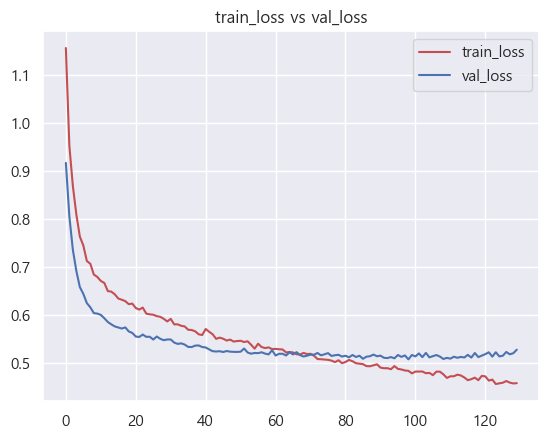

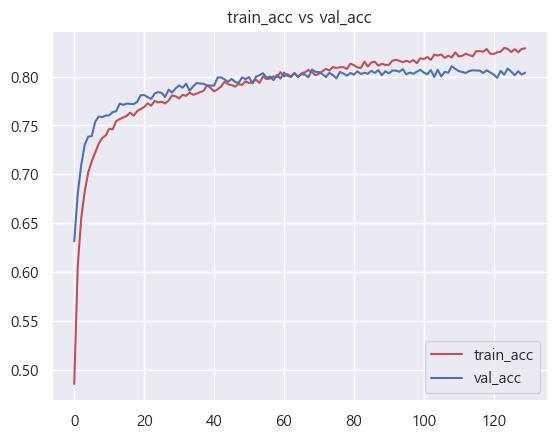

<Figure size 640x480 with 0 Axes>

In [1229]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

In [1230]:
#Model Save
best_model.save_weights('model_weights.h5')
best_model.save('model_keras.h5')

In [1231]:
from keras.models import load_model
model=load_model('model_final.h5')

# Confusion Matrix

In [1232]:
from sklearn.metrics import confusion_matrix
y_prob = model.predict(X_test) 
results = y_prob.argmax(axis=-1)
cm = confusion_matrix(np.where(y_test == 1)[1], results)

125/125 [==============================] - 0s 1ms/step


In [1233]:
cm_df = pd.DataFrame(cm, index =['랩/힙합', '록/메탈', '발라드', '클래식'],
                     columns = ['랩/힙합', '록/메탈', '발라드', '클래식']
                    )

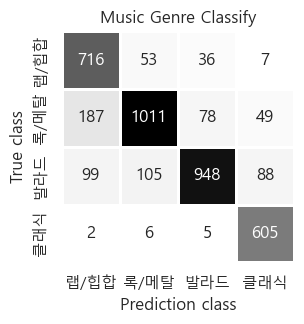

In [1234]:
plt.figure(figsize = (3,3))
sns.heatmap(cm_df, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('Music Genre Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

# Classification Report

In [1235]:
print(classification_report(np.where(y_test == 1)[1], results))
# f1-score의 밸런스가 어느정도 맞춰진 모습

              precision    recall  f1-score   support

           0       0.71      0.88      0.79       812
           1       0.86      0.76      0.81      1325
           2       0.89      0.76      0.82      1240
           3       0.81      0.98      0.89       618

    accuracy                           0.82      3995
   macro avg       0.82      0.85      0.83      3995
weighted avg       0.83      0.82      0.82      3995



# Roc Curve

ROC AUC score: 0.9731135341788834


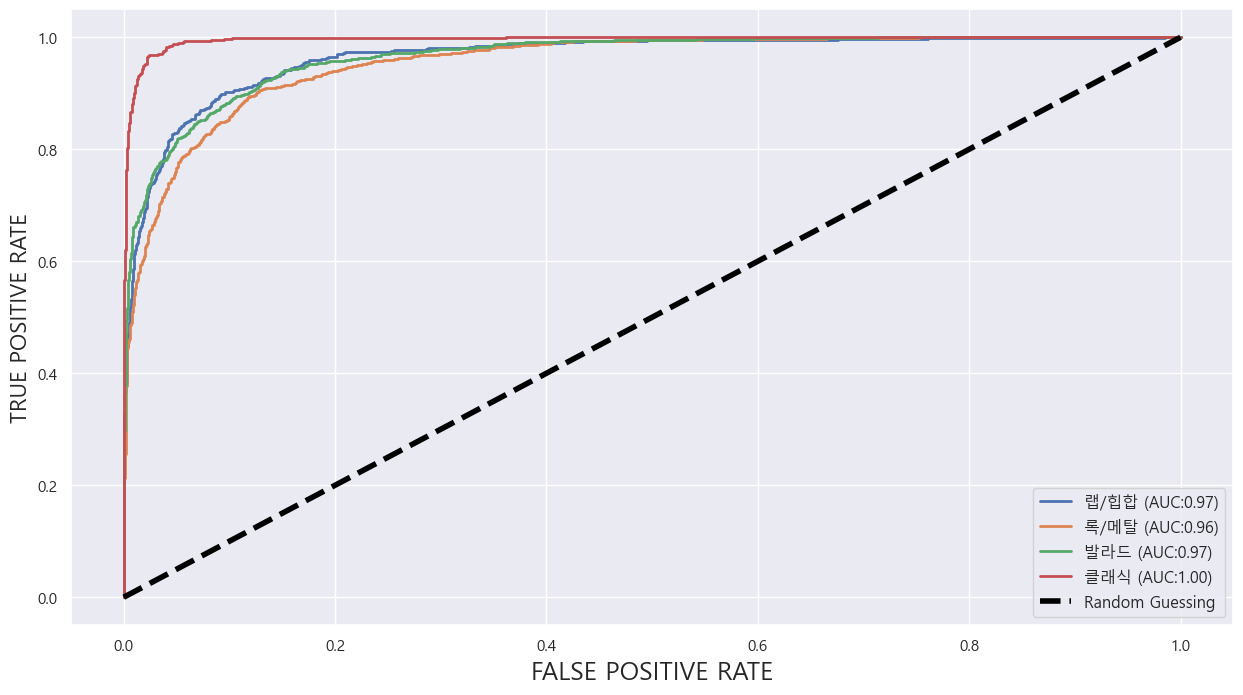

In [1236]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(['랩/힙합', '록/메탈', '발라드', '클래식']):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:',multiclass_roc_auc_score(y_test,pred , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()